In [2]:
import pandas as pd
from pathlib import Path
import numpy as np

import jax
import jax.numpy as jnp
from jax import random



## data split for training, val, test

In [3]:
DATA_DIR = Path("data")  # adjust if needed

prices_adj = pd.read_csv(DATA_DIR / "etf_prices_adj.csv",
                         index_col=0, parse_dates=True)
log_ret = pd.read_csv(DATA_DIR / "etf_returns_log.csv",
                      index_col=0, parse_dates=True)
simple_ret = pd.read_csv(DATA_DIR / "etf_returns_simple.csv",
                         index_col=0, parse_dates=True)

prices_adj = prices_adj.sort_index()
log_ret = log_ret.sort_index()
log_ret = log_ret.reindex(prices_adj.index).ffill().dropna(how="all")

simple_ret = simple_ret.sort_index()
simple_ret = simple_ret.reindex(prices_adj.index).ffill().dropna(how="all")


In [4]:
# ----- define split dates -----
TRAIN_END = "2016-12-31"
VAL_END   = "2021-12-31"

train_ret = log_ret.loc[:TRAIN_END]
val_ret   = log_ret.loc[TRAIN_END:VAL_END]
test_ret  = log_ret.loc[VAL_END:]


simple_ret_train = simple_ret.loc[train_ret.index]
simple_ret_val   = simple_ret.loc[val_ret.index]
simple_ret_test  = simple_ret.loc[test_ret.index]

train_prices = prices_adj.loc[train_ret.index]
val_prices   = prices_adj.loc[val_ret.index]
test_prices  = prices_adj.loc[test_ret.index]

print("Train period:", train_ret.index[0], "→", train_ret.index[-1])
print("Train size: ", train_prices.shape, train_ret.shape )
print("Val period:  ", val_ret.index[0], "→", val_ret.index[-1])
print("Val size: ", val_prices.shape, val_ret.shape )
print("Test period: ", test_ret.index[0], "→", test_ret.index[-1])
print("Test size: ", test_prices.shape, test_ret.shape )


Train period: 2006-02-07 00:00:00 → 2016-12-30 00:00:00
Train size:  (2844, 8) (2844, 8)
Val period:   2017-01-02 00:00:00 → 2021-12-31 00:00:00
Val size:  (1305, 8) (1305, 8)
Test period:  2021-12-31 00:00:00 → 2025-11-18 00:00:00
Test size:  (1013, 8) (1013, 8)


In [5]:
mu = train_ret.mean()
sigma = train_ret.std().replace(0, np.nan)

def normalize_returns(df):
    return (df - mu) / sigma

train_ret_norm = normalize_returns(train_ret)
val_ret_norm   = normalize_returns(val_ret)
test_ret_norm  = normalize_returns(test_ret)
log_ret_norm   = normalize_returns(log_ret) 


## Calculation of rolling mean for window = 15 days

In [6]:
WINDOW = 15

roll_mean_train = train_ret_norm.rolling(WINDOW).mean()
roll_std_train  = train_ret_norm.rolling(WINDOW).std()

roll_mean_val = val_ret_norm.rolling(WINDOW).mean()
roll_std_val  = val_ret_norm.rolling(WINDOW).std()

In [7]:
log_ret_train_norm_cut = train_ret_norm.iloc[WINDOW-1:]
roll_mean_train_cut    = roll_mean_train.iloc[WINDOW-1:]
roll_std_train_cut     = roll_std_train.iloc[WINDOW-1:]
simple_ret_train_cut   = simple_ret_train.iloc[WINDOW-1:]

log_ret_val_norm_cut = val_ret_norm.iloc[WINDOW-1:]
roll_mean_val_cut    = roll_mean_val.iloc[WINDOW-1:]
roll_std_val_cut     = roll_std_val.iloc[WINDOW-1:]
simple_ret_val_cut   = simple_ret_val.iloc[WINDOW-1:]

In [8]:
print("Train cut length:", len(log_ret_train_norm_cut))
print("Val cut length:", len(log_ret_val_norm_cut))
log_ret_train_norm_cut

Train cut length: 2830
Val cut length: 1291


,US_REITs_VNQ,US_SmallCap_IWM,Gold_GLD,US_LargeCap_SPY,Europe_VGK,DevExUS_EFA,US_Bonds_AGG,Emerging_EEM
Date,,,,,,,,
2006-02-27,-0.005173,0.155965,-0.625896,0.008538,0.091258,0.225392,-0.708664,0.441855
2006-02-28,-0.183671,-0.862173,1.205823,-0.787860,-0.517683,-0.616703,0.609794,-1.300480
2006-03-01,0.258843,1.129582,0.024305,0.687278,0.548308,0.668182,-0.040340,1.335707
2006-03-02,-0.069234,-0.284800,0.890661,-0.028613,0.091025,-0.131524,-0.836775,0.034870
2006-03-03,-0.269385,-0.338082,-0.671032,-0.395175,0.177124,-0.279163,-0.681001,-0.829781
...,...,...,...,...,...,...,...,...
2016-12-26,-0.012273,-0.017324,-0.018567,-0.022412,-0.006337,-0.005701,-0.049435,-0.004591
2016-12-27,0.085828,0.267376,0.447932,0.176270,0.083206,-0.085918,-0.283582,0.209909
2016-12-28,-0.295584,-0.672628,0.202628,-0.687812,-0.391032,-0.258457,0.448108,0.365006


## DRL first attempt of optimization on training on train evaluation on val

In [9]:
# --- Build base features: [last_ret_norm, mean, std] ---
def build_feat_base(last_ret_df, mean_df, std_df) -> np.ndarray:
    # All [T, N_assets], same index/order
    last_ret = last_ret_df.values
    mean_v   = mean_df.values
    std_v    = std_df.values
    return np.concatenate([last_ret, mean_v, std_v], axis=1)  # [T, 3*N_assets]

feat_base_train_np = build_feat_base(
    log_ret_train_norm_cut,
    roll_mean_train_cut,
    roll_std_train_cut,
)
feat_base_val_np = build_feat_base(
    log_ret_val_norm_cut,
    roll_mean_val_cut,
    roll_std_val_cut,
)

asset_simple_train_np = simple_ret_train_cut.values  # [T_train, N_assets]
asset_simple_val_np   = simple_ret_val_cut.values   # [T_val, N_assets]

N_assets = asset_simple_train_np.shape[1]
F = feat_base_train_np.shape[1]
print("N_assets:", N_assets, "Feature dim:", F)

# --- Convert to JAX arrays ---
feat_base_train = jnp.array(feat_base_train_np, dtype=jnp.float32)
feat_base_val   = jnp.array(feat_base_val_np, dtype=jnp.float32)

asset_simple_train = jnp.array(asset_simple_train_np, dtype=jnp.float32)
asset_simple_val   = jnp.array(asset_simple_val_np, dtype=jnp.float32)


N_assets: 8 Feature dim: 24


In [10]:
WINDOW = 15
N_assets = log_ret_train_norm_cut.shape[1]

def make_dataset_with_window(
    log_ret_norm_df: pd.DataFrame,
    simple_ret_df: pd.DataFrame,
    window: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Build (feat_base, asset_simple) for one split.

    feat_t = [flatten(last window of normalized log returns), rolling mean_t, rolling std_t]

    Returns
    -------
    feat_base : np.ndarray  [T_eff, F]
    asset_simple : np.ndarray [T_eff, N_assets]
    """
    # rolling on normalized returns
    roll_mean = log_ret_norm_df.rolling(window).mean()
    roll_std  = log_ret_norm_df.rolling(window).std()

    ret_norm = log_ret_norm_df.values           # [T, N_assets]
    mean_v   = roll_mean.values                 # [T, N_assets]
    std_v    = roll_std.values                  # [T, N_assets]
    simple_v = simple_ret_df.values             # [T, N_assets]

    T, N = ret_norm.shape
    feats = []
    simple_out = []

    # start at index window-1 so window is full
    for i in range(window-1, T):
        window_slice = ret_norm[i - window + 1 : i + 1, :]   # [window, N]
        window_flat = window_slice.reshape(-1)               # [window * N]
        feat_t = np.concatenate([window_flat, mean_v[i], std_v[i]], axis=0)
        feats.append(feat_t)
        simple_out.append(simple_v[i])

    feat_base = np.stack(feats, axis=0)          # [T_eff, window*N + 2N]
    asset_simple = np.stack(simple_out, axis=0)  # [T_eff, N]
    return feat_base, asset_simple

# Train
feat_base_train_np, asset_simple_train_np = make_dataset_with_window(
    train_ret_norm,
    simple_ret_train,
    WINDOW,
)

# Val
feat_base_val_np, asset_simple_val_np = make_dataset_with_window(
    val_ret_norm,
    simple_ret_val,
    WINDOW,
)

print("feat_base_train_np shape:", feat_base_train_np.shape)
print("asset_simple_train_np shape:", asset_simple_train_np.shape)
print("feat_base_val_np shape:", feat_base_val_np.shape)
print("asset_simple_val_np shape:", asset_simple_val_np.shape)

N_assets = asset_simple_train_np.shape[1]
F = feat_base_train_np.shape[1]   # this will now be WINDOW * N_assets + 2 * N_assets
print(F)
feat_base_train = jnp.array(feat_base_train_np, dtype=jnp.float32)
feat_base_val   = jnp.array(feat_base_val_np, dtype=jnp.float32)

asset_simple_train = jnp.array(asset_simple_train_np, dtype=jnp.float32)
asset_simple_val   = jnp.array(asset_simple_val_np, dtype=jnp.float32)



feat_base_train_np shape: (2830, 136)
asset_simple_train_np shape: (2830, 8)
feat_base_val_np shape: (1291, 136)
asset_simple_val_np shape: (1291, 8)
136


In [11]:
# pseudo-code in your notebook

rets = simple_ret_train  # DataFrame with SPY, AGG, GLD, ...

ann_factor = 252

for col in rets.columns:
    r = rets[col].values
    mu = r.mean() * ann_factor
    sigma = r.std() * jnp.sqrt(ann_factor)
    sharpe = mu / (sigma + 1e-8)
    print(col, mu, sigma, sharpe)
asset_labels = list(log_ret.columns)        # e.g. ["US_LargeCap_SPY", "Gold_GLD", ..., "US_Bonds_AGG", ...]
asset_labels_full = asset_labels + ["Cash"] # used elsewhere
N_assets = len(asset_labels)
num_weights = N_assets + 1                  # +1 for cash

prior_w = jnp.zeros((num_weights,), dtype=jnp.float32)

idx_spy = asset_labels.index("US_LargeCap_SPY")   # or whatever your SPY column label is
idx_agg = asset_labels.index("US_Bonds_AGG")      # your AGG label

prior_w = prior_w.at[idx_spy].set(1)
prior_w = prior_w.at[idx_agg].set(0)

print(prior_w)

US_REITs_VNQ 0.12398690189873413 0.33980295 0.36487883
US_SmallCap_IWM 0.09967694392405065 0.24891211 0.40045035
Gold_GLD 0.07796916417721518 0.19776312 0.3942553
US_LargeCap_SPY 0.0900415529113924 0.19802994 0.45468655
Europe_VGK 0.06010938455696201 0.25993785 0.23124522
DevExUS_EFA 0.050603922405063305 0.24026969 0.210613
US_Bonds_AGG 0.04088842392405063 0.05023725 0.8139063
Emerging_EEM 0.07585557265822784 0.32450476 0.23375797
[0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [12]:
from v1_DRL import TrainConfig, train_drl
from v1_MLP import MLP
# Total input dim for the MLP:
#  - feat_base has dim F = 3 * N_assets
#  - rollout_episode concatenates prev weights of size (N_assets + 1)
state_dim = F + (N_assets + 1)
hidden_dim = 64
output_dim = N_assets + 1  # 8 assets + cash

key = random.PRNGKey(0)
mlp_init = MLP.init(key, state_dim, hidden_dim, output_dim)

cfg = TrainConfig(
    num_iters=101,
    lr=0.005,
    cost_rate=0.0001,
    temperature=1,
    log_every=20,
    k_rebalance = 30,
    horizon_H = 90,
    w_sharpe=0.6,
    w_return=0.4,
    lambda_prior=0.5

)

mlp_trained, train_losses, val_losses = train_drl(
    mlp_init,
    feat_base_train,
    asset_simple_train,
    cfg,
    feat_base_val,
    asset_simple_val,
    prior_weights=prior_w
)





[DRL] iter    0 | train_loss=-3.315811 | train_score=3.315811 | val_loss=-8.534506 | val_score=8.534506
[DRL] iter   20 | train_loss=-8.352119 | train_score=8.352119 | val_loss=-8.414896 | val_score=8.414896
[DRL] iter   40 | train_loss=-12.532890 | train_score=12.532890 | val_loss=-8.135395 | val_score=8.135395
[DRL] iter   60 | train_loss=-14.947882 | train_score=14.947882 | val_loss=-8.027613 | val_score=8.027613
[DRL] iter   80 | train_loss=-16.898512 | train_score=16.898512 | val_loss=-8.000627 | val_score=8.000627
[DRL] iter  100 | train_loss=-17.996408 | train_score=17.996408 | val_loss=-7.815757 | val_score=7.815757


Train total return: 2.764739513397217
Val total return: 0.5762543678283691
weights_train shape: (2830, 9)
Total train return (sum of rewards): 2.764739513397217
Total val return (sum of rewards):   0.5762543678283691


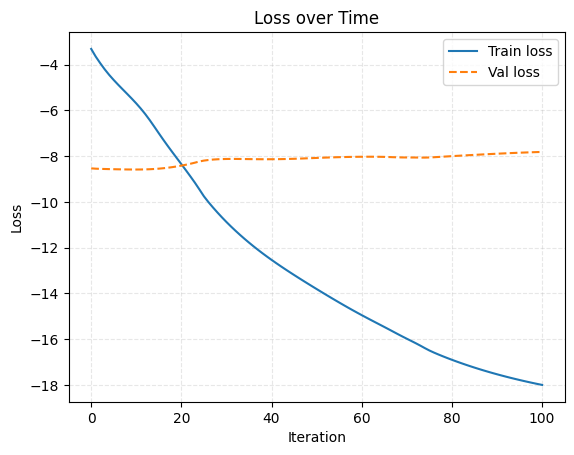

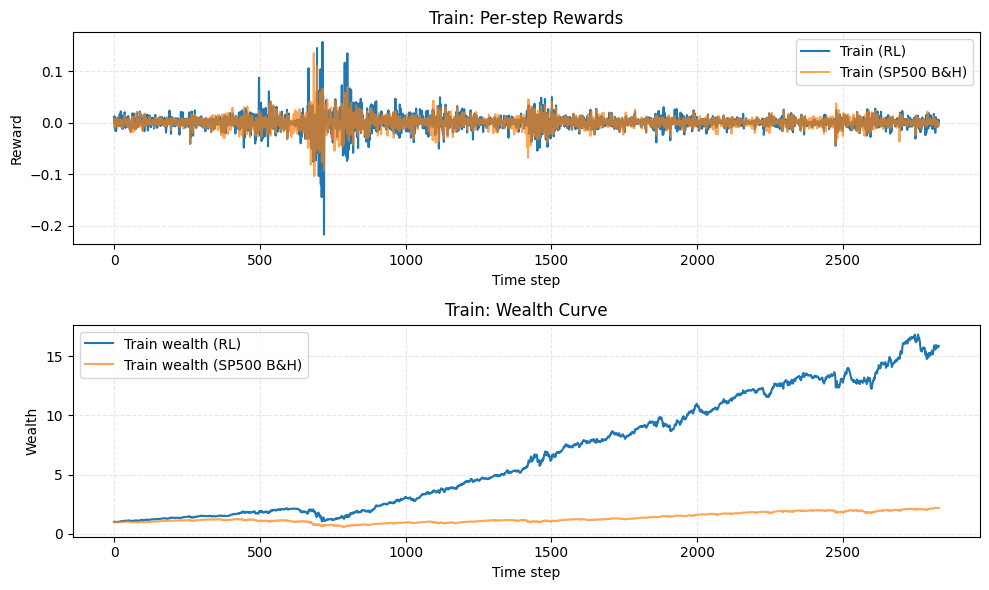

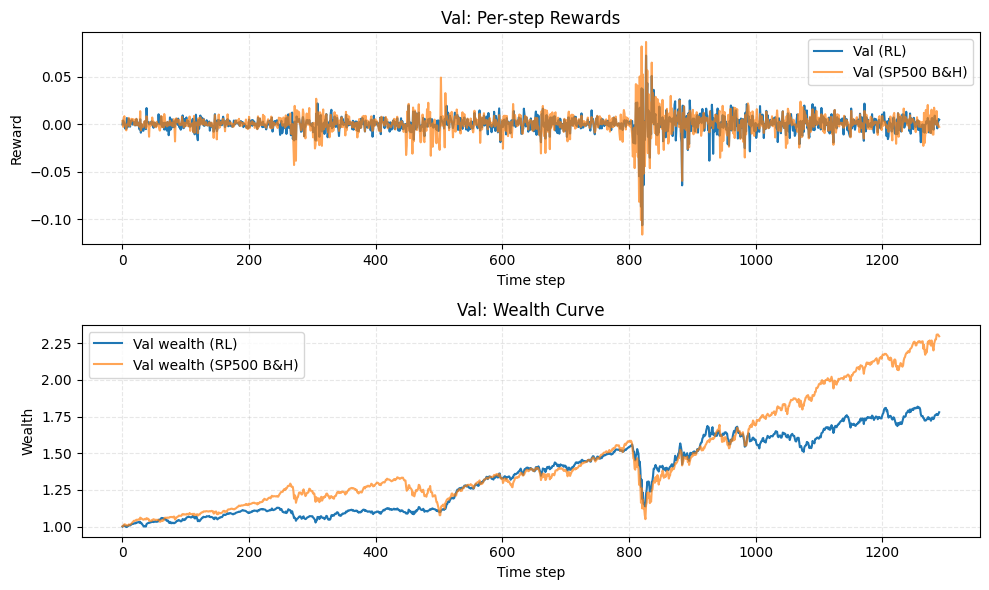

In [13]:
from visualizations import plot_loss_curve, plot_episode_performance_split, plot_allocation_over_time
from v1_DRL import evaluate_policy_with_weights

# Evaluate on train with weights
rewards_train, total_train, weights_train = evaluate_policy_with_weights(
    mlp_trained,
    feat_base_train,
    asset_simple_train,
    cost_rate=cfg.cost_rate,
    temperature=cfg.temperature,
    k_rebalance=cfg.k_rebalance,
)

# Evaluate on val with weights (if you also want allocation on val)
rewards_val, total_val, weights_val = evaluate_policy_with_weights(
    mlp_trained,
    feat_base_val,
    asset_simple_val,
    cost_rate=cfg.cost_rate,
    temperature=cfg.temperature,
    k_rebalance=cfg.k_rebalance,
)

print("Train total return:", float(total_train))
print("Val total return:", float(total_val))
print("weights_train shape:", weights_train.shape)


print("Total train return (sum of rewards):", float(total_train))
print("Total val return (sum of rewards):  ", float(total_val))

# --- SP500 / SPY baseline (buy & hold) ---
# Adjust this if your SPY column has a different name.
SPY_COL = "US_LargeCap_SPY"  # or "SPY", check print(log_ret.columns) above

spy_train_simple = simple_ret_train_cut[SPY_COL].values
spy_val_simple   = simple_ret_val_cut[SPY_COL].values

# --- Visualizations ---
plot_loss_curve(train_losses, val_losses)


fig_train, fig_val = plot_episode_performance_split(
    rewards_train,
    rewards_val,
    baseline_simple_train=spy_train_simple,
    baseline_simple_val=spy_val_simple,
    initial_wealth=1.0,
)


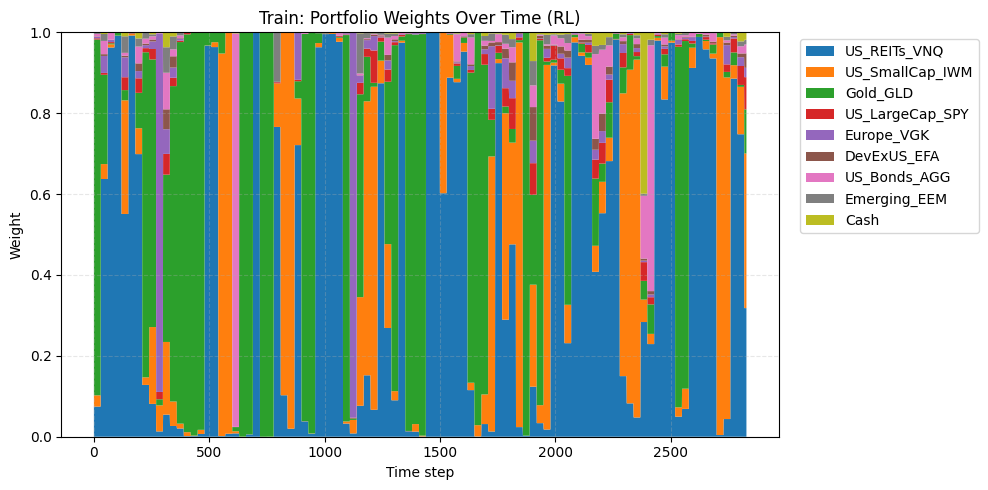

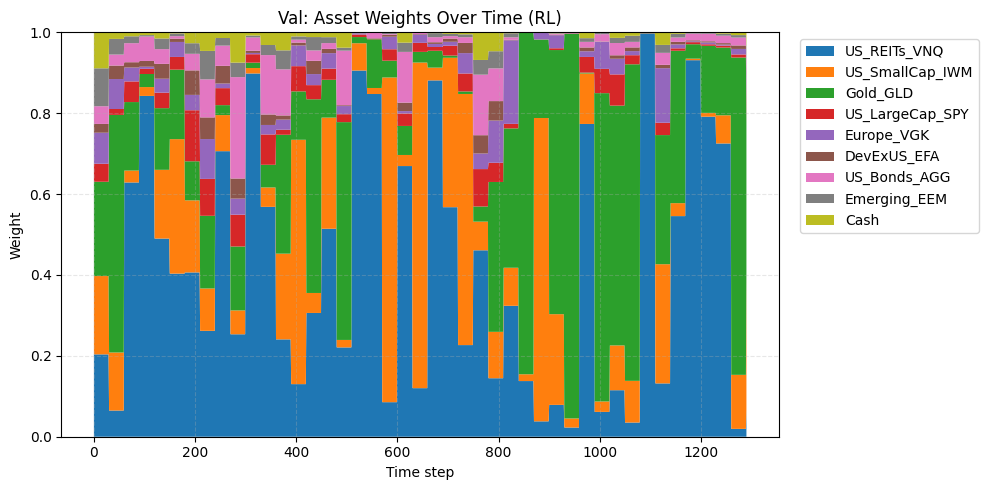

<Axes: title={'center': 'Val: Asset Weights Over Time (RL)'}, xlabel='Time step', ylabel='Weight'>

In [14]:

# asset labels: 10 ETFs + Cash
asset_labels_full = list(log_ret.columns) + ["Cash"]

# plot including cash:
plot_allocation_over_time(
    np.array(weights_train),
    asset_labels=asset_labels_full,
    title="Train: Portfolio Weights Over Time (RL)",
)

# or exclude cash if you want to focus only on risky assets
asset_labels_no_cash = list(log_ret.columns)
plot_allocation_over_time(
    np.array(weights_val),
    asset_labels=asset_labels_full,
    title="Val: Asset Weights Over Time (RL)",
)



In [25]:

from v1_evolutionary_strategy import ESConfig, train_es


state_dim = F + (N_assets + 1)  # features + previous weights
hidden_dim = 64
output_dim = N_assets + 1       # 8 ETFs + cash

key = random.PRNGKey(0)
mlp_init = MLP.init(key, state_dim, hidden_dim, output_dim)

# 60/40 prior: SPY / AGG
asset_labels = list(log_ret.columns)    # whatever you use
num_weights = N_assets + 1

prior_w = jnp.zeros((num_weights,), dtype=jnp.float32)
idx_spy = asset_labels.index("US_LargeCap_SPY")
idx_agg = asset_labels.index("US_Bonds_AGG")

prior_w = prior_w.at[idx_spy].set(0.6)
prior_w = prior_w.at[idx_agg].set(0.4)
# cash left at 0.0; you can set small cash if you want

# ES hyperparams – reuse economic bits from your TrainConfig
es_cfg = ESConfig(
    num_generations=100,
    pop_size=64,
    sigma=0.02,
    lr=0.03,

    cost_rate=0.0001,       # from your TrainConfig
    temperature=10.0,
    k_rebalance=30,
    horizon_H=90,
    w_sharpe=0.6,
    w_return=0.4,
    lambda_prior=0.0,
)

mlp_es, es_train_losses, es_val_losses = train_es(
    mlp_init,
    feat_base_train,
    asset_simple_train,
    es_cfg,
    feat_base_val=feat_base_val,
    asset_simple_val=asset_simple_val,
    prior_weights=prior_w,
)


[ES] gen    0 | train_loss=-4.651106 | train_score=4.651106 | val_loss=-8.988956 | val_score=8.988956
[ES] gen   10 | train_loss=-5.488559 | train_score=5.488559 | val_loss=-8.981156 | val_score=8.981156
[ES] gen   20 | train_loss=-6.235510 | train_score=6.235510 | val_loss=-9.013340 | val_score=9.013340
[ES] gen   30 | train_loss=-6.787162 | train_score=6.787162 | val_loss=-9.016257 | val_score=9.016257
[ES] gen   40 | train_loss=-7.440187 | train_score=7.440187 | val_loss=-9.046308 | val_score=9.046308
[ES] gen   50 | train_loss=-8.554070 | train_score=8.554070 | val_loss=-9.079556 | val_score=9.079556
[ES] gen   60 | train_loss=-10.252707 | train_score=10.252707 | val_loss=-9.033978 | val_score=9.033978
[ES] gen   70 | train_loss=-11.551204 | train_score=11.551204 | val_loss=-8.953800 | val_score=8.953800
[ES] gen   80 | train_loss=-12.379906 | train_score=12.379906 | val_loss=-8.934305 | val_score=8.934305
[ES] gen   90 | train_loss=-13.301018 | train_score=13.301018 | val_loss=-9.

ES Train total return: 2.452406883239746
ES Val total return:   0.40728649497032166
ES weights_train shape: (2830, 9)


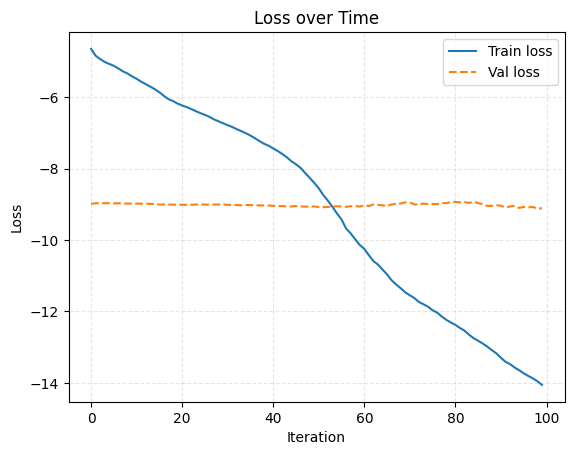

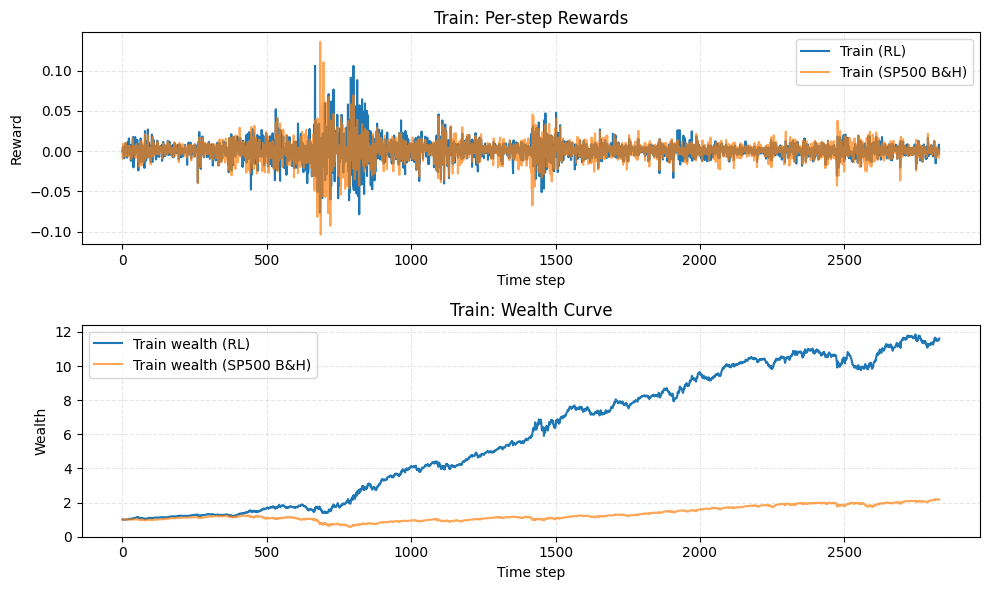

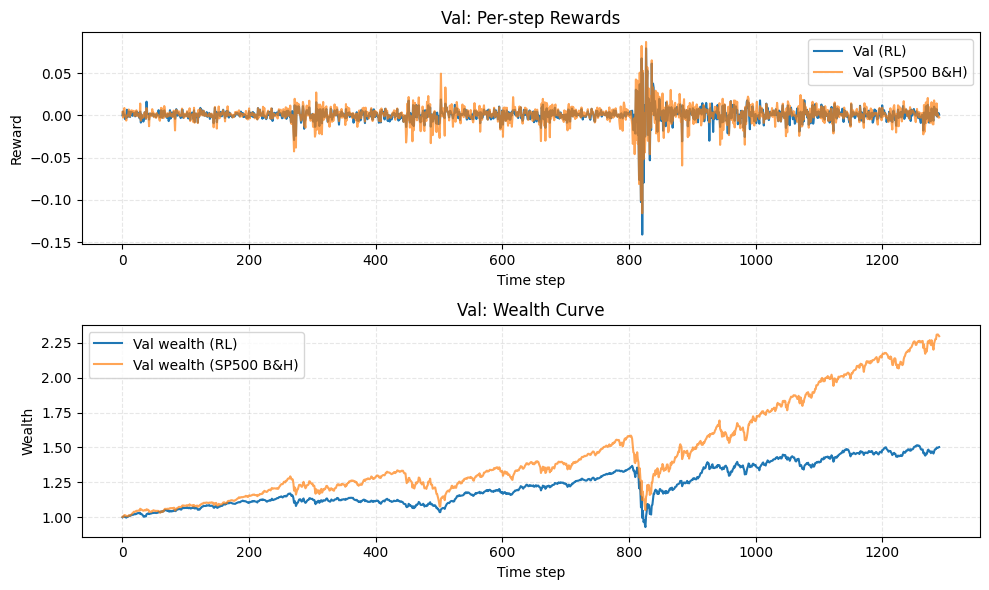

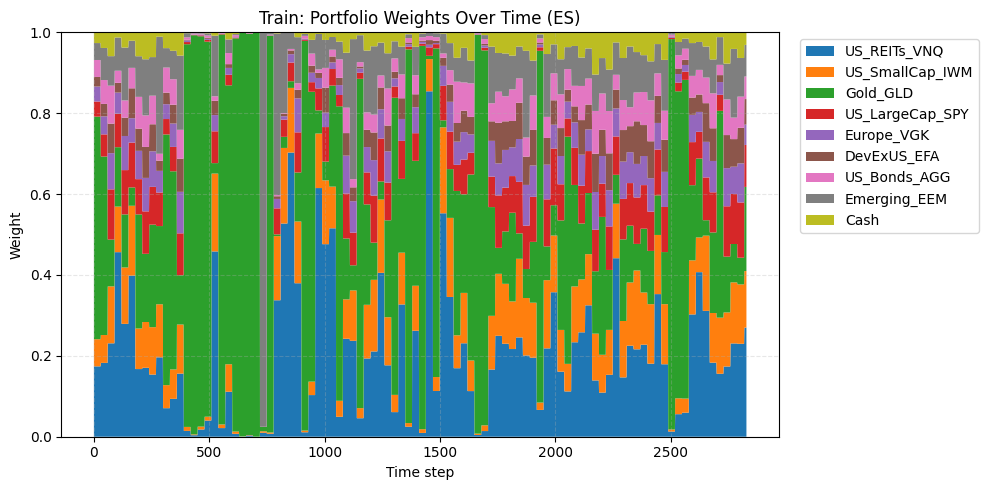

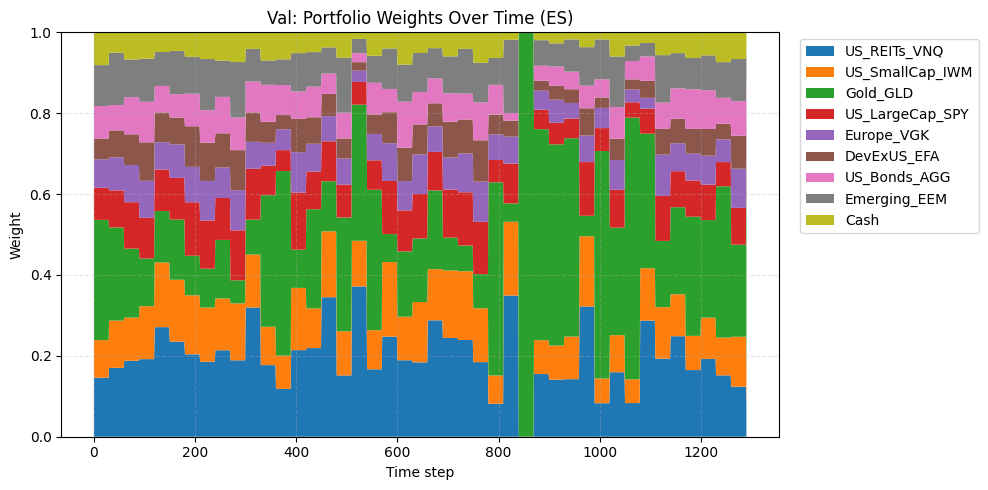

<Axes: title={'center': 'Val: Portfolio Weights Over Time (ES)'}, xlabel='Time step', ylabel='Weight'>

In [26]:
from visualizations import plot_loss_curve, plot_episode_performance_split, plot_allocation_over_time
from v1_DRL import evaluate_policy_with_weights

# --- Evaluate ES policy on train & val ---

rewards_train_es, total_train_es, weights_train_es = evaluate_policy_with_weights(
    mlp_es,
    feat_base_train,
    asset_simple_train,
    cost_rate=es_cfg.cost_rate,
    temperature=es_cfg.temperature,
    k_rebalance=es_cfg.k_rebalance,
)

rewards_val_es, total_val_es, weights_val_es = evaluate_policy_with_weights(
    mlp_es,
    feat_base_val,
    asset_simple_val,
    cost_rate=es_cfg.cost_rate,
    temperature=es_cfg.temperature,
    k_rebalance=es_cfg.k_rebalance,
)

print("ES Train total return:", float(total_train_es))
print("ES Val total return:  ", float(total_val_es))
print("ES weights_train shape:", weights_train_es.shape)

# --- SP500 / SPY baseline (buy & hold), same as before ---

SPY_COL = "US_LargeCap_SPY"  # keep this consistent with your DataFrame

spy_train_simple = simple_ret_train_cut[SPY_COL].values
spy_val_simple   = simple_ret_val_cut[SPY_COL].values

# --- Loss curves for ES (mirrors your gradient plot) ---

plot_loss_curve(es_train_losses, es_val_losses)

# --- Performance vs SPY for ES policy (same as before, just *_es) ---

fig_train_es, fig_val_es = plot_episode_performance_split(
    rewards_train_es,
    rewards_val_es,
    baseline_simple_train=spy_train_simple,
    baseline_simple_val=spy_val_simple,
    initial_wealth=1.0,
)

# --- Allocation over time for ES policy (train & val) ---

asset_labels_full = list(log_ret.columns) + ["Cash"]

plot_allocation_over_time(
    weights_train_es,
    asset_labels=asset_labels_full,
    title="Train: Portfolio Weights Over Time (ES)",
)

plot_allocation_over_time(
    weights_val_es,
    asset_labels=asset_labels_full,
    title="Val: Portfolio Weights Over Time (ES)",
)
